# Fuzzy Logic Model: Andropogon gerardii

Andropogon gerardii habitat characteristics and tolerances:
- Soil type: Lowland silt and clay loam
- Soil horizon > 10in
- elevation: 
        CO     3,400 to 9,500 feet (1,036-2,896 m)
        NM     3,500 to 9,000 feet (1,067-2,743 m)
        MT     3,300 to 4,000 feet (1,006-1,219 m)
        WY     3,600 to 9,000 feet (1,067-2,743 m)
(Source 4)
- Optimal soil temperature: 25C. "Soil temperatures below 20 °C caused significant reductions in foliar nitrogen (N) and phosphorus(P) concentration". "reduced photosynthetic rates observed at 5 and 10 °C Tsoil" "Net photosynthesis was < 12 /^mol m"^ s"' at 5 and 10 °C Tsoil and > 20 micromol\ m^-2 s^-1 at 15-40 °C.". Based on the graphs in this study, it seems that bluestem would be growth-limited above 30 and below 20 degrees C, and severely limited outside 15-35 degrees. (Source 5)
- min soil temp -15C (source 8)
- well drained or moist soil, full sun (Source 8)
- Precip: 10-60mm / yr (source7)
- pH range: 6.0-7.5 (source 10). Another source (11) says that it does fine with pH 5.5, so we'll use this as out lower-range tolerance. Optimal then is 6.5 (halfway)

In [2]:
from math import floor, ceil

import cartopy.crs as ccrs
import geopandas as gpd
import hvplot.pandas
import hvplot.xarray
import numpy as np
import rioxarray as rxr
import rioxarray.merge as rxrmerge
import skfuzzy
import xarray as xr

In [3]:
%conda install skfuzzy

Retrieving notices: ...working... done
Note: you may need to restart the kernel to use updated packages.

Channels:
 - defaults
 - conda-forge
Platform: win-64
Solving environment: ...working... failed



PackagesNotFoundError: The following packages are not available from current channels:

  - skfuzzy

Current channels:

  - defaults
  - https://conda.anaconda.org/conda-forge/win-64

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [4]:
%store -r shey_gdf curl_gdf

In [5]:
grassland_url = (
    "https://data.fs.usda.gov/geodata/edw/edw_resources/shp"
    "/S_USA.NationalGrassland.zip")
grassland_gdf = gpd.read_file(grassland_url)
grassland_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NATIONALGR  20 non-null     object  
 1   GRASSLANDN  20 non-null     object  
 2   GIS_ACRES   20 non-null     float64 
 3   SHAPE_AREA  20 non-null     float64 
 4   SHAPE_LEN   20 non-null     float64 
 5   geometry    20 non-null     geometry
dtypes: float64(3), geometry(1), object(2)
memory usage: 1.1+ KB


In [6]:
shey_gdf.to_crs(ccrs.Mercator()).hvplot(tiles='EsriNatGeo', line_width=3, fill_color=None)

c:\Users\moenc\miniconda3\envs\earth-analytics-python\Lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [x,y]

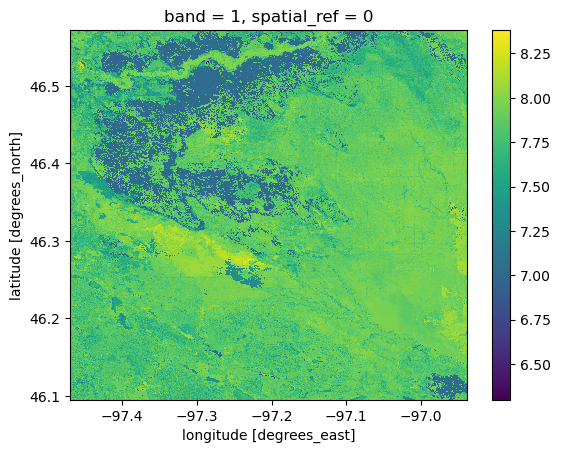

In [7]:
xmin, ymin, xmax, ymax = shey_gdf.total_bounds
tiles = []
for lat_min in range (floor(ymin), ceil(ymax)):
        for lon_min in range (floor(xmin), ceil(xmax)):
                    lat_max, lon_max = lat_min +1, lon_min +1
                    ph_url = (
                            "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0"
                            "/ph/mean/60_100"
                            f"/lat{lat_min}{lat_max}_lon{lon_min}{lon_max}.tif")
                    tiles.append(rxr.open_rasterio(ph_url))

ph_da = rxrmerge.merge_arrays(tiles).rio.clip_box(*shey_gdf.total_bounds)
ph_da.plot()
                    
                            


In [ ]:
year_min, year_max = 2026, 2056
model = "BNU-ESM"
emissions = 'rcp85'
variable = 'pr'
periods = []
buffer_bounds = None
for start_year in range (year_min, year_max, 5):

SyntaxError: incomplete input (3728556329.py, line 7)

In [15]:
year_min, year_max = 2026, 2056
model = "BNU-ESM"
emissions = 'rcp85'
variable = 'pr'
periods = []
buffer_bounds = None
for start_year in range(year_min, year_max, 5):
    end_year = start_year + 4
    climate_url = (
        "http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2"
        f"/{model}/macav2metdata_{variable}_{model}_r1i1p1_{emissions}"
        f"_{start_year}_{end_year}_CONUS_monthly.nc")
    period_da = (
        xr.open_dataset(climate_url, mask_and_scale=True)
        .squeeze()
        .precipitation)
    period_da = period_da.assign_coords(lon=(period_da.lon + 180) % 360 - 180)
    period_da = period_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
    if buffer_bounds is None:
        shey_gdf_reproj = shey_gdf.to_crs(period_da.rio.crs)
        xmin, ymin, xmax, ymax = shey_gdf_reproj.total_bounds
        b = .1
        buffer_bounds = [xmin - b, ymin - b, xmax + b, ymax + b]
    periods.append(period_da.rio.clip_box(*buffer_bounds))

precip_da = (
    xr.concat(periods, dim='time')
    .resample({'time': 'Y'})
    .sum()
    .rio.write_crs(4326)
    .rio.reproject_match(precip_min_da))

precip_min_da = precip_da.min('time')
precip_max_da = precip_da.max('time')
precip_mean_da = precip_da.mean('time')
precip_mean_da.plot()

<string>:6: FutureWarning: 'Y' is deprecated and will be removed in a future version. Please use 'YE' instead of 'Y'.


NameError: name 'precip_min_da' is not defined

In [ ]:
precip_min_da.plot.hist()

In [ ]:
# precip 11-45 (in) 279-1143
# ph 4.8-8
precip_suit = ((precip_min_da > 310) & (precip_max_da < 825))
ph_suit = ((precip_min_da > 4.8) & (precip_min_da < 8))

In [ ]:
precip_suit.plot()

In [ ]:
(precip_suit * ph_suit).plot()

In [ ]:
ph_da.values

In [ ]:
shape = ph_da.values.shape
ph_fuzz = ph_da.copy()
ph_fuzz.values = (
    np.reshape(
        skfuzzy.trimf(ph_da.values.flatten(), [4.8, (4.8 + 8)/2, 8]),
        shape)
)
ph_fuzz.plot()


In [ ]:
shape = precip_min_da.values.shape
precip_min_fuzz = precip_min_da.copy()
precip_min_fuzz.values = (
    np.reshape(
        skfuzzy.trimf(precip_min_da.values.flatten(), 
                      [310, (310 + 825)/2, 825]),
        shape)
)
precip_min_fuzz.plot()

In [ ]:
((ph_fuzz * precip_min_fuzz) > .05).plot()